In [418]:
import sys
#import h5py
import numpy as np
import operator
import pandas
import pymorphy2
import math
from scipy.stats.distributions import binom

# Определяем входные данные
Наши входные данные это новостной массив за 2014 год.

In [2]:
input_path  = './data/' 
input_file = input_path + 'news_src.txt' 

--------------------
I - Frequency
=====

<h2> Итерируемся по файлу и подсчитываем частотность вхождения биграмм</h2><br>
<li>Биграммой считаем пару слов, следующих друг за другом. <br>
<li>Подсчитаем количество биграмм в первом миллионе
<br>
<hr>
Каждая строка файла представляет один документ. Первое поле урл документа, все остальное это документ. Урл отделен табуляцией. Предложения также разделены табуляциями. Термы в предложениях нормализованы.  

In [63]:

#
# получить набор биграмм согласно заданным параметрам
# use_pos - используем часть речи при подсчете
# 
#
def get_bigram_set(input_file, max_row_count=1e+6):
    bigramm_set = {}
    with open(input_file) as ifile:
        # итерация по всем документам
        for i, line in enumerate(ifile):
            parts = line.strip().split('\t')
            url = parts[0] # первое поле урл
            # пропускаем пустые документы
            if len(parts) <=1 : continue
            # 
            for j, sentens in enumerate(parts[1:]):
                sent = sentens.strip().split()
                slen = len(sent)
                if slen == 0: continue
                ar = []
                for iw, w in enumerate(sent):
                    if iw + 1 < slen:
                        bigram = w + ' ' + sent[iw+1]
                        if bigram not in bigramm_set:
                            bigramm_set[bigram] = 0
                        bigramm_set[bigram] = bigramm_set[bigram] + 1 

            sys.stderr.write('\r'+str(i) + " total bigram: " + str(len(bigramm_set)))
            if i == max_row_count:
                break
    return bigramm_set               

In [37]:
##
## Получаем таблицу pandas из набора биграм, отсортированную по частотности
##
def get_pandas_table(bigramm_set, top_n = 20):
    sorted_bigrams = sorted(bigramm_set.items(), key=operator.itemgetter(1), reverse=True)
    ####
    # Отбираем топ 20
    ###
    top_20_names = []
    top_20_vaues = []
    for i, k in enumerate(sorted_bigrams):
        top_20_names.append(k[0]) 
        top_20_vaues.append(k[1])
        if i == 20 : 
            break
    ###        
    # Делаем таблицу pandas
    ###
    dt = ['Частота']
    values = np.asarray(top_20_vaues)
    index = top_20_names
    return pandas.DataFrame(values, index=index, columns=dt)    

<h2>Сначал пытаемся отобрать самые частотные биграммы и выводим топ 20 самых частотных биграмм</h2>

In [39]:
bigramm_set = get_bigram_set(input_file)



1000000 total bigram: 18803442

<b> Используем для этого pandas


In [61]:
get_pandas_table(bigramm_set)

,Частота
о это,184456
один из,179537
а также,154665
2015 год,151915
тот что,150860
в тот,141986
что в,140030
пресс служба,129071
и в,117989
в это,113372


<h2>Теперь используем информацию о частях речи</h2>
<li>**AN** - прилагательное + существительное
<li>**NN** - существительное + существительное 

<br>Для простоты считаем биграмы двоек, тройки игнорируем:

<li>**AAN**
<li>**ANN**
<li>**NNN**
<li>**NPN** - существительное + предлог + существительное

In [59]:
####
## Хелпер для мапирования слов в части речи  
##№
class POSTagger:
    __stemmer = pymorphy2.MorphAnalyzer()
    __cache = {}
    def parse(self, token):
        form = ('', '')
        if token not in self.__cache:
            res = self.__stemmer.parse(token)[0]
            form = ( res.normal_form, res.tag.POS )
            self.__cache[token] = form
        else :
            form = self.__cache[token]
        return form[1]
pos_tagger = POSTagger()

#
# получить набор биграмм согласно заданным параметрам
# use_pos - используем часть речи при подсчете
# 
#
def get_pos_bigram_set(input_file, max_row_count=1e+6):
    bigramm_set = {}
    with open(input_file) as ifile:
        # итерация по всем документам
        for i, line in enumerate(ifile):
            parts = line.strip().split('\t')
            url = parts[0] # первое поле урл
            # пропускаем пустые документы
            if len(parts) <=1 : continue
            # 
            for j, sentens in enumerate(parts[1:]):
                sent = sentens.strip().split()
                slen = len(sent)
                if slen == 0: continue
                sent = [ ss.decode('utf-8') for ss in sent]
                ar = []
                for iw, w in enumerate(sent):
                    if iw + 1 < slen:
                        pos1 = pos_tagger.parse(w)
                        pos2 = pos_tagger.parse(sent[iw+1])
                        if (pos1 == 'ADJF' or pos1 == 'NOUN') and pos2 == 'NOUN':
                            bigram = w + ' ' + sent[iw+1]
                            if bigram not in bigramm_set:
                                bigramm_set[bigram] = 0
                            bigramm_set[bigram] = bigramm_set[bigram] + 1 

            sys.stderr.write('\r'+str(i) + " total bigram: " + str(len(bigramm_set)))
            if i == max_row_count:
                break
    return bigramm_set       

 --- Эту переменную будем использовать дальше, она содержит статистику по биграммам нашего массива ---

In [60]:
pos_bigramm_set = get_pos_bigram_set(input_file)

1000000 total bigram: 4685306

In [62]:
get_pandas_table(pos_bigramm_set)

,Частота
пресс служба,129071
тот число,69728
уголовный дело,57108
риа новость,54353
миллион рубль,52868
настоящее время,44442
миллиард рубль,44368
прошлое год,43679
владимир путин,41806
российский федерация,37965


------------------
II - Mean and Variance
=====

** Подсчитаем распределение одного слова относительно другого ** <br>
Строим гистограммы распределений.

In [116]:
#
# Ищем распределение по ппозициям двух слов
# word 1 - базовое
# word 2 - сопровождающее 
# 
#
def get_distrib_bigram_set(input_file, word1, word2, win=3, max_row_count=1e+6):
    bigramm_set = {}
    with open(input_file) as ifile:
        # итерация по всем документам
        for i, line in enumerate(ifile):
            parts = line.strip().split('\t')
            url = parts[0] # первое поле урл
            # пропускаем пустые документы
            if len(parts) <=1 : continue
            # 
            for j, sentens in enumerate(parts[1:]):
                sent = sentens.strip().split()
                slen = len(sent)
                if slen == 0: continue
                ar  = {}
                ar[word1] = []
                ar[word2] = []
                sent = [ ss.decode('utf-8') for ss in sent]
                for iw, w in enumerate(sent):
                    if w in ar:
                        ar[w].append(iw)
                minpos = 99999
                rpos   = 0 
                for w1pos in ar[word1]:
                    for w2pos in ar[word2]:
                        rpos = w2pos - w1pos
                        if abs(rpos) <= win:
                            if minpos >  abs(rpos):
                                minpos = abs(rpos)
                if minpos < 99999:
                    if rpos not in bigramm_set:
                        bigramm_set[rpos] = 0
                    bigramm_set[rpos] = bigramm_set[rpos] + 1
                                
            sys.stderr.write('\r'+str(i) + " total bigram: " + str(len(bigramm_set)))
            if i == max_row_count:
                break
    return bigramm_set

In [163]:
# -------------
# Строим гистограммы распределений
# -------------
import matplotlib.pyplot as plt
%matplotlib inline

def draw_distrib(distrib, w1, w2):
    fig = plt.gcf()
    fig.set_size_inches(10, 2)
    sorted_distrib = sorted(distrib.items(), key=operator.itemgetter(0))
    plt.bar(range(len(distrib)), [d[1] for d in sorted_distrib], align='center')
    plt.xticks(range(len(distrib)), [d[0] for d in sorted_distrib] )
    values = []
    for v in sorted_distrib:
        v = [v[0]] * v[1]
        values.extend(v) 
    print 'mean:' + '%.2f'%np.mean(values) + " std: " + '%.2f'%np.std(values)  + '/ (' + w1 + ' ' + w2 + ')'

    plt.show()

----------------
** Первая пара слов *'волатильность'  и 'сильный'* **

In [117]:
distrib = get_distrib_bigram_set(input_file, u'волатильность', u'сильный')

1000000 total bigram: 4

mean:-1.02 std: 0.52/ (волатильность сильный)


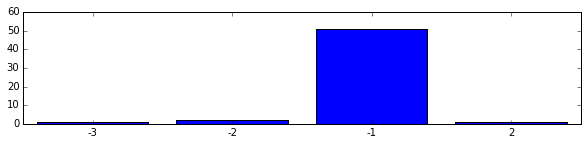

In [164]:
draw_distrib(distrib, u'волатильность', u'сильный')

----------------
**  *'поддержка'  и 'сильный'* **

In [142]:
distrib_2 = get_distrib_bigram_set(input_file, u'поддержка', u'сильный')

1000000 total bigram: 9

mean:-1.10 std: 1.74/ (поддержка сильный)


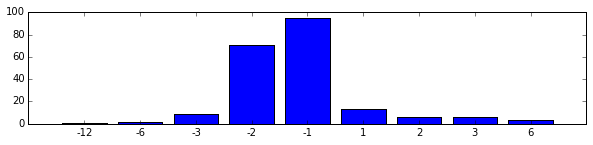

In [165]:
draw_distrib(distrib_2, u'поддержка', u'сильный')

----------------
**  *'для'  и 'сильный'* **

In [130]:
distrib_3 = get_distrib_bigram_set(input_file, u'для', u'сильный')

1000000 total bigram: 23

mean:-0.75 std: 3.84/ (для сильный)


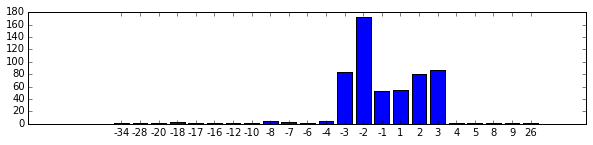

In [166]:
draw_distrib(distrib_3, u'для', u'сильный')

## Топ 12 биграм среднее и стандартное отклонение
Считаем среднее и дисперсию для топ 12 биграмм полученных в предыдущем разделе

In [168]:
top_bigrams_for_check = get_pandas_table(pos_bigramm_set)

 ** Определяем методы подсета ** 

In [251]:
def calculate_top_distribs():
    top_distribs = {}
    for i, bigram in enumerate(top_bigrams_for_check.index):
        if i == 12: break
        top_distribs[bigram] = get_distrib_bigram_set(input_file, bigram.split()[1], bigram.split()[0])
    return top_distribs

##
## Получаем таблицу pandas из набора биграм, отсортированную по частотности
##
def get_pandas_table_for_mean_and_std(bigramm_set):
    sorted_bigrams = sorted(bigramm_set.items(), key=operator.itemgetter(1), reverse=True)
    ####
    # Отбираем топ 20
    ###
    top_20_names = []
    top_20_vaues = []
    for i, k in enumerate(sorted_bigrams):
        top_20_names.append(k[0]) 
        top_20_vaues.append([k[1][0], k[1][1], k[1][2]])
    ###        
    # Делаем таблицу pandas
    ###
    dt = ['Частота', 'Mean', 'Std']
    values = np.asarray(top_20_vaues)
    index = top_20_names
    return pandas.DataFrame(values, index=index, columns=dt) 

def calculate_mean_and_variance(top_distribs, top_bigrams):
    bigramm_set = {}
    for i, bigram in enumerate(top_distribs.keys()):
        values = []
        for v in top_distribs[bigram].items():
            v = [v[0]] * v[1]
            values.extend(v)
        bigramm_set[bigram] = ( top_bigrams[bigram],  np.mean(values), np.std(values) )
    return bigramm_set

 * Считаем распределения

In [ ]:
top_distribs = calculate_top_distribs()

53998 total bigram: 28

In [249]:
bigramms_mean_std = calculate_mean_and_variance(top_distribs, top_bigrams_for_check['Частота'])

* Выводим таблицу статистики

In [252]:
get_pandas_table_for_mean_and_std( bigramms_mean_std )

,Частота,Mean,Std
пресс служба,129071,-1.064374,1.230774
тот число,69728,-0.813762,2.234214
уголовный дело,57108,-0.969454,2.317335
риа новость,54353,-1.001122,0.183002
миллион рубль,52868,-0.973434,2.168581
настоящее время,44442,-1.121742,1.469904
миллиард рубль,44368,-0.692835,3.690560
прошлое год,43679,-1.791702,4.549470
владимир путин,41806,-1.007878,2.046794
российский федерация,37965,-0.702253,2.904589


-----
III - Статистическая проверка гипотез
======
-----
## 1. Критерий Стьюдента. t - критерий 

Проверим гипотезу, что биграмма *"миллион рублей"* является коллокацией

In [259]:
def get_words_frequency(input_file, words_set, max_row_count=1e+6):
    total_words = 0
    with open(input_file) as ifile:
        # итерация по всем документам
        for i, line in enumerate(ifile):
            parts = line.strip().split('\t')
            url = parts[0] # первое поле урл
            # пропускаем пустые документы
            if len(parts) <=1 : continue
            # 
            for j, sentens in enumerate(parts[1:]):
                sent = sentens.strip().split()
                slen = len(sent)
                if slen == 0: continue
                
                sent = [ ss.decode('utf-8') for ss in sent]
                for iw, w in enumerate(sent):
                    if w in words_set:
                        words_set[w] = words_set[w] + 1
                    total_words = total_words + 1
                                
            sys.stderr.write('\r'+str(i) + " total words: %d"%total_words)
            if i == max_row_count:
                break
    return total_words

### Подсчитаем достоверность биграммы 'миллион рублей'

In [331]:
words_set = { u'миллион':0, u'рубль':0 } 
total_words = get_words_frequency(input_file, words_set)

1000000 total words: 186419524

Считаем вероятности:<br>
P(миллион)<br>
P(рубль)

In [273]:
print "частота слова 'миллион': %d "%words_set[ u'миллион']
print "частота слова 'рубль': %d "%words_set[ u'рубль']
print "всего слов: %d\n"%total_words
print 'P(миллион) = %0.4f'%(float(words_set[ u'миллион']) / total_words) + '\nP(рубль) = %0.4f'%(float(words_set[ u'рубль']) / total_words)
print 'H0 = P(миллион)*P(рубль) =  %0.7f' % (float(words_set[ u'миллион']) / total_words * float(words_set[ u'рубль']) / total_words)

частота слова 'миллион': 215131 
частота слова 'рубль': 268089 
всего слов: 186419524

P(миллион) = 0.0012
P(рубль) = 0.0014
H0 = P(миллион)*P(рубль) =  0.0000017


Процесс рандомной генерации биграмм, в результате, превращается в попытки Бернулли: когда 1 соответствует присутствию биграммы о - отсутствию. В этом случе среднее и дисперсия для гипотезы:   

In [277]:
p_gen =  (float(words_set[ u'миллион']) / total_words * float(words_set[ u'рубль']) / total_words) 
print "mean = p = %0.7f"%p_gen
print "var = p(1-p) = %0.8f"%(p_gen*(1-p_gen)) 

mean = p = 0.0000017
var = p(1-p) = 0.00000166


Среднее же для целой биграммы, которая у нас встречается

In [280]:
n_mil_rubl = top_bigrams_for_check['Частота'][u'миллион рубль']
n_mil_rubl

52868

 Учитывая,  что среднее и дисперсия примерно равны в нашем случае получаем

In [301]:
x_mil_rub_mean = n_mil_rubl/float(total_words)
print "mean('миллион рубль') = var('миллион рубль') = p ('миллион рубль') = %0.7f"%(x_mil_rub_mean)

mean('миллион рубль') = var('миллион рубль') = p ('миллион рубль') = 0.0002836


Проводим t - тест

In [302]:
t_test = (x_mil_rub_mean - p_gen) / math.sqrt(x_mil_rub_mean / float(total_words) )
print 't = %.7f'%t_test

t = 228.5848919


* t >> 2.576. Гипотезу о независимости слов в коллокации не принимаем

### Теперь подсчитаем достоверность биграммы 'новая компания'

In [352]:
words_set2 = { u'новый':0, u'компания':0} 
total_words = get_words_frequency(input_file, words_set2)
pos_bigramm_set[u'новый компания']

1000000 total words: 186419524

335

In [333]:
def caclculate_t_crit(w1, w2, bigram,  total):
    H0 = w1/float(total) * w2/float(total)
    p_bigram = bigram / float(total)
    return (p_bigram - H0)/math.sqrt(p_bigram/ float(total))

In [353]:
t_crit = caclculate_t_crit(words_set2[u'новый'], words_set2[u'компания'], pos_bigramm_set[u'новый компания'], total_words)
confidence_alfa =  2.576 
print t_crit
if t_crit < confidence_alfa:
    print 't criterion less then confidence alfa: %.7f < 2.576, can not reject H0'%t_crit

3.79729669979


* В  этом случае мы отвергаем гипотезу 0 о независимости слов

----
## 2. Критерий Пирсона

Рассчитаем распределение частотностей для 'новая компания'. 

In [376]:
print 'новый: \t\t%d'%words_set2[u'новый'] 
print 'компания: \t%d'%words_set2[u'компания']
print 'w1 = новый и w2 = компания: \t%d'%pos_bigramm_set[u'новый компания'] 
print 'w1 = новый и w2 не= компания: \t%d'% (words_set2[u'новый'] - pos_bigramm_set[u'новый компания'] )
print 'w2 = компания  и w1 не= новый: \t%d'% (words_set2[u'компания'] - pos_bigramm_set[u'новый компания'] )
print 'w2 не= компания и w1 не= новый: %d'% (total_words - words_set2[u'компания'] - words_set2[u'новый'])
print 'всего слов: \t\t%d'%total_words

новый: 		211876
компания: 	233599
w1 = новый и w2 = компания: 	335
w1 = новый и w2 не= компания: 	211541
w2 = компания  и w1 не= новый: 	233264
w2 не= компания и w1 не= новый: 185974049
всего слов: 		186419524


* ---
Ожидаемая частота встречаемости биграммы 'новая компания' - это произведение предельных вероятностей для слов новый и компания умноженное на общее количество слов 

In [377]:
print 'E (новая компания) = %0.2f'% (words_set2[u'новый'] * words_set2[u'компания']/float(total_words) )

E (новая компания) = 265.50


In [401]:
X2_matrix = np.array( [[float(pos_bigramm_set[u'новый компания']) , float(words_set2[u'компания'] - pos_bigramm_set[u'новый компания'] )],
                       [ float(words_set2[u'новый'] - pos_bigramm_set[u'новый компания'] ), float(total_words - words_set2[u'компания'] - words_set2[u'новый'])]] )

In [416]:
print X2_matrix[1,0]

211541.0


Рассчитаем коитерий X^2

In [417]:
X_2 = total_words * math.pow( X2_matrix[0,0] * X2_matrix[1,1] - X2_matrix[0,1] * X2_matrix[1,0], 2)
mul = (X2_matrix[0,0] + X2_matrix[0,1]) * ( X2_matrix[0,0] + X2_matrix[1,0] ) 
mul = mul * (X2_matrix[0,1] + X2_matrix[1,1]) * ( X2_matrix[1,0] + X2_matrix[1,1])
X_2 = X_2 / mul
print "X^2 = %0.4f"%X_2

X^2 = 18.2375


* Гипотеза не может быть отброшена, не по одному уровню вероятности

----
## 3. Критерий отношения правдоподобия
Построим отношения правдоподобия для биграм образованных словом мощный <br>
* Считаем статистику по словам, входящим в биграмму слова мощный

In [432]:
words_for_powerfull = {}
for bigram_pair in pos_bigramm_set.items():
    if bigram_pair[0].split()[0] == u'мощный' and  bigram_pair[1] > 1:
            words_for_powerfull[bigram_pair[0].split()[1] ] = 0
words_for_powerfull[u'мощный'] = 0
get_words_frequency(input_file, words_for_powerfull)

1000000 total words: 186419524

186419524

* Рассчитываем отношения правдоподобия для каждой биграммы и делаем из нее таблицу pandas DataFrame
c1 - частота первого слова <br>
с2 - частота второго слова <br>
с12 - частота биграммы <br>
Вероятности: <br>
p - вероятность слова 2 в биграмме <br>
p1 - вероятность биграммы <br>
p2 - вероятности слова 2 при условии отсутствия слова 1 <br>

In [448]:
# определяем частоты
c1  = float(words_for_powerfull[u'мощный'])
N = float(total_words)

# правдоподобия для биграмм
bigram_likelyhoods = {}

for power_full_pair in words_for_powerfull.items():
    if  power_full_pair[0] == u'мощный': continue
    
    bigram = u'мощный ' + power_full_pair[0]
    c12 = float(pos_bigramm_set[ bigram ]  )
    c2 =  float(power_full_pair[1])
    
    p =  c2/ N
    p1 = c12 / c1
    p2 = (c2 - c12 ) / (N - c1)
    
    log_Lh1 = math.log(binom.cdf(c12, c1, p)) + math.log(binom.cdf(c2-c12, N- c1, p))
    log_Lh2 = math.log(binom.cdf(c12, c1, p1)) + math.log(binom.cdf(c2-c12, N- c1, p2))
    
    likelyhood = -2*(log_Lh1 - log_Lh2)
    
    bigram_likelyhoods[bigram] = (likelyhood, c1, c2, c12 )

# сортируем и строим таблицу pandas DataFrame
sorted_bigrams_lh = sorted(bigram_likelyhoods.items(), key=operator.itemgetter(1), reverse=True)
bigram_names = []
bigram_vaues = []

for i, k in enumerate(sorted_bigrams_lh):
    if i > 30: break
    bigram_names.append(k[0]) 
    bigram_vaues.append([k[1][0], k[1][1], k[1][2], k[1][3]])
###        
# Делаем таблицу pandas
###
dt = ['-2log Lh', 'C1', 'C2', 'C12']
values = np.asarray(bigram_vaues)
index = bigram_names
pandas_bigrams_lh = pandas.DataFrame(values, index=index, columns=dt)

In [449]:
pandas_bigrams_lh

,-2log Lh,C1,C2,C12
мощный россия,66.800607,14709,513837,2
мощный землетрясение,58.521963,14709,5490,543
мощный взрыв,44.635622,14709,20928,930
мощный работа,19.562579,14709,242103,4
мощный город,15.886387,14709,212631,4
мощный решение,15.403840,14709,185295,3
мощный матч,14.409602,14709,222457,5
мощный результат,14.223097,14709,175997,3
мощный пресс,13.519567,14709,193078,4
мощный регион,10.386798,14709,144900,3


---- 
## Взаимная информация

Рассчитаем точечную взаимную информацию (PMI) для биграм со словом мощный

In [478]:
bigram_mutual_info = {}
log_2 = math.log(2.)
for bigramm  in bigram_likelyhoods.items():
    p_xy = bigramm[1][3] / float(total_words)
    p_x = bigramm[1][1] / float(total_words)
    p_y = bigramm[1][2] / float(total_words)
    over = p_xy/(p_x*p_y)
    bits = math.log(over)/log_2
    bigram_mutual_info[bigramm[0]] = ( bits, p_xy * bits, bigramm[1][1], bigramm[1][2], bigramm[1][3])
sorted_bigrams_mi = sorted(bigram_mutual_info.items(), key=operator.itemgetter(1), reverse=True)
bigram_names = []
bigram_vaues = []

for i, k in enumerate(sorted_bigrams_mi):
    if i > 30: break
    bigram_names.append(k[0]) 
    bigram_vaues.append([k[1][0], k[1][1], k[1][2], k[1][3], k[1][4]])
###        
# Делаем таблицу pandas
###
dt = ['pmi', 'mi', 'C1', 'C2', 'C12']
values = np.asarray(bigram_vaues)
index = bigram_names
pandas_bigrams_mi = pandas.DataFrame(values, index=index, columns=dt)    

* Выводим таблицу значений

In [479]:
pandas_bigrams_mi

,pmi,mi,C1,C2,C12
мощный 23мр,12.629566,1.354962e-07,14709,4,2
мощный 20мр,12.127066,3.903153e-07,14709,17,6
мощный наркос,12.044604,1.292204e-07,14709,6,2
мощный медиаимперия,11.822211,1.268345e-07,14709,7,2
мощный дожимной,11.542103,2.476587e-07,14709,17,4
мощный иммунодепрессант,11.542103,2.476587e-07,14709,17,4
мощный нейротоксин,11.492063,3.082312e-07,14709,22,5
мощный антипиар,11.459641,2.458893e-07,14709,18,4
мощный плавник,11.451229,1.167117e-06,14709,86,19
мощный жиросжигатель,11.381639,2.442156e-07,14709,19,4
